Name: Andrew Lake

Student Number: 22259775

# Lab 5: Regression and Dimensionality Reduction

This exercise repeats the same scenario as Lab 4, but this time we train a regression model, i.e. a model for numeric prediction. We also add dimensionality reduction element to the training pipeline. Note that dimensionality reduction can be included in classification pipelines in the same way. 

In this exercise we use the `fish market` dataset, taken from https://www.kaggle.com/aungpyaeap/fish-market. Each example in this dataset represents a fish. The first column is the name of the fish species and the other six columns are numerical characteristics of the fish. 

In this exercise, we aim at training a regression model for predicting the weight of a fish from its other characteristics. We will evaluate two regression algorithms, `RandomForestRegressor` and `LinearRegression`, to choose the better one for training the final model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's examine values in the categorical column `Species` first.

In [4]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Now, let's check for missing values and outliers.

In [5]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [6]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [7]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

They all look OK, it mkes sense to have 0 as a value for number of children

In [8]:
df[df.children == 0]

age  gender     bmi  children smoker     region  insurance_cost
1      18    male  34.100         0     no  southeast      1137.01100
2      18  female  26.315         0     no  northeast      2198.18985
4      18  female  35.625         0     no  northeast      2211.13075
6      18  female  30.115         0     no  northeast     21344.84670
7      18    male  23.750         0     no  northeast      1705.62450
...   ...     ...     ...       ...    ...        ...             ...
1331   64  female  39.700         0     no  southwest     14319.03100
1332   64  female  35.970         0     no  southeast     14313.84630
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1337   64    male  23.760         0    yes  southeast     26926.51440

[574 rows x 7 columns]

It is just one data row. We will drop it later as it cannot be used for training or test. The model that we will train, though, can be used to predict th weight of this fish.

Next, let's check for outliers in the numerical columns

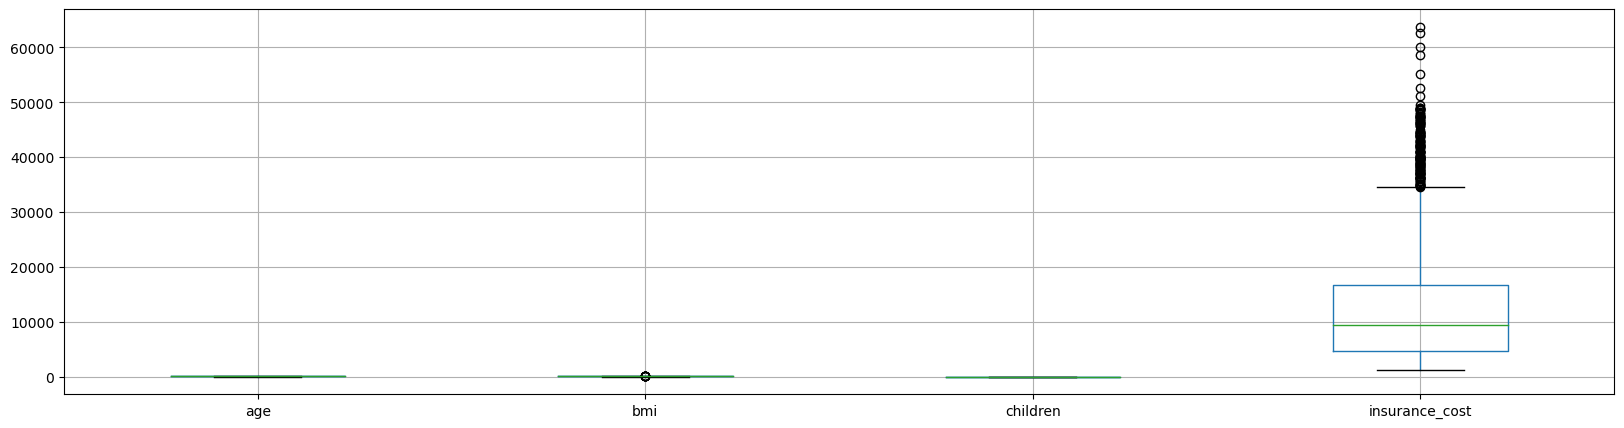

In [9]:
df.boxplot(figsize=(20,5))
plt.show()

WE see alot of outliers in the insurance_cost section

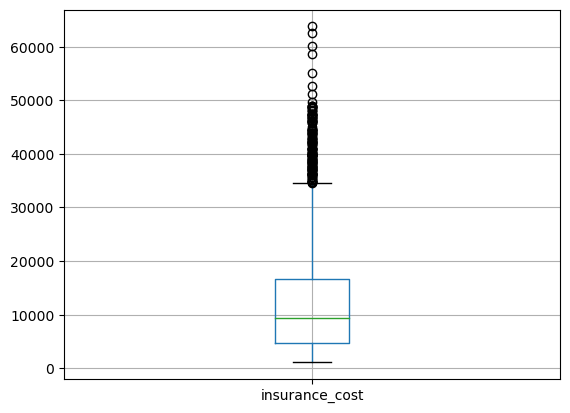

In [10]:
df.boxplot(column=['insurance_cost'])
plt.show()

Let's see what data attributes corresponds with insurance_cost in excess of ~35,000

For BMI between 18.5 and 24.9 is considered normal (according to google!!)

In [11]:
df[df['insurance_cost'] > 35000]

age  gender     bmi  children smoker     region  insurance_cost
9      18  female  36.850         0    yes  southeast     36149.48350
38     18    male  38.170         0    yes  southeast     36307.79830
40     18  female  42.240         0    yes  southeast     38792.68560
87     19    male  36.955         0    yes  northwest     36219.40545
128    19  female  32.490         0    yes  northwest     36898.73308
...   ...     ...     ...       ...    ...        ...             ...
1300   63  female  32.200         2    yes  southwest     47305.30500
1317   64  female  31.300         2    yes  southwest     47291.05500
1319   64  female  33.800         1    yes  southwest     47928.03000
1325   64    male  33.880         0    yes  southeast     46889.26120
1336   64    male  36.960         2    yes  southeast     49577.66240

[133 rows x 7 columns]

So BMI is high that seems expected

We're seeing alot of south.. but this is only a subset of all values, let's see if we can get their count

In [12]:
df.loc[df['insurance_cost'] > 35000, ['gender', 'region', 'smoker']].value_counts()

gender  region     smoker
male    southeast  yes       36
        southwest  yes       20
female  southeast  yes       18
male    northeast  yes       17
        northwest  yes       11
female  northeast  yes       10
        northwest  yes        9
        southwest  yes        9
                   no         2
        southeast  no         1
dtype: int64

So we're seeing southeast male who smokes is the must common outlier.

It is expected to see so many smokers for each

I think it would be interesting to explore further why a region could affect things, but that is out of scope for now

Finally lets check what the max outlier is... for science!!

In [13]:
df.loc[df['insurance_cost'].idxmax()]

age                        54
gender                 female
bmi                     47.41
children                    0
smoker                    yes
region              southeast
insurance_cost    63770.42801
Name: 1079, dtype: object

We see a high bmi and a high-ish age, and a smoker. I'm curious if that is the oldest from the dataset

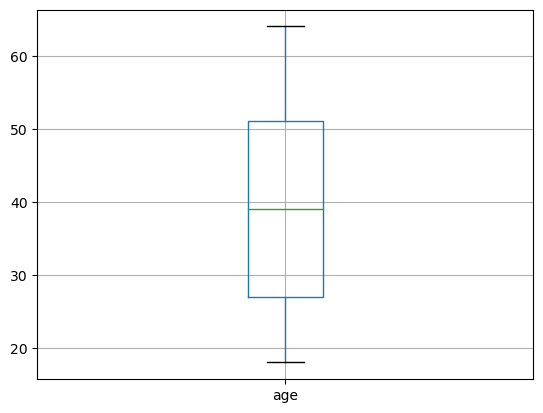

In [14]:
df.boxplot(column=['age'])
plt.show()

54 isn't an outlier or even the max, but it is in the last quartile

## Data Preparation

I don't think we need to drop anything

We can replace smoker, gender, and region with numerical columns.  Gender and smoker are binary so they can be changed to 0 and 1, but for region we have 4 values, is it better to one-hot encode or to simply change to 0 to 3. There is no intrisic order or hierarchy so we will one-hot encode

In [15]:
df = pd.get_dummies(df, columns=['region'], 
                        #dummy_na=True, 
                        drop_first=True)

In [16]:
# Create a mapper

scale_mapper_bin_smoker = {
    "no": 0,
    "yes": 1,
}
scale_mapper_bin_gender = {
    "male": 0,
    "female": 1,
}

df['gender'] = df['gender'].replace(scale_mapper_bin_gender)
df['smoker'] = df['smoker'].replace(scale_mapper_bin_smoker)

Let's examine the transformed dataset.

In [17]:
df.head()

age  gender     bmi  children  smoker  insurance_cost  region_northwest  \
0   18       0  33.770         1       0      1725.55230                 0   
1   18       0  34.100         0       0      1137.01100                 0   
2   18       1  26.315         0       0      2198.18985                 0   
3   18       1  38.665         2       0      3393.35635                 0   
4   18       1  35.625         0       0      2211.13075                 0   

   region_southeast  region_southwest  
0                 1                 0  
1                 1                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

In [18]:
df.tail()

age  gender     bmi  children  smoker  insurance_cost  region_northwest  \
1333   64       1  31.825         2       0     16069.08475                 0   
1334   64       1  26.885         0       1     29330.98315                 1   
1335   64       0  26.410         0       0     14394.55790                 0   
1336   64       0  36.960         2       1     49577.66240                 0   
1337   64       0  23.760         0       1     26926.51440                 0   

      region_southeast  region_southwest  
1333                 0                 0  
1334                 0                 0  
1335                 0                 0  
1336                 1                 0  
1337                 1                 0

Since there are no obvious outliers, we will apply `StandardScaler` to all predictor columns witha very simple (compared to example A) pre-rpocessing pipeline.

In [19]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

What is out output parameter? I think the insurance_cost is what is of interest to us

In [20]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [22]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.860:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitt

The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [23]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [24]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.742:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\lake9\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_

The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [25]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [26]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We will use a Pandas bar plots to compare the results. 

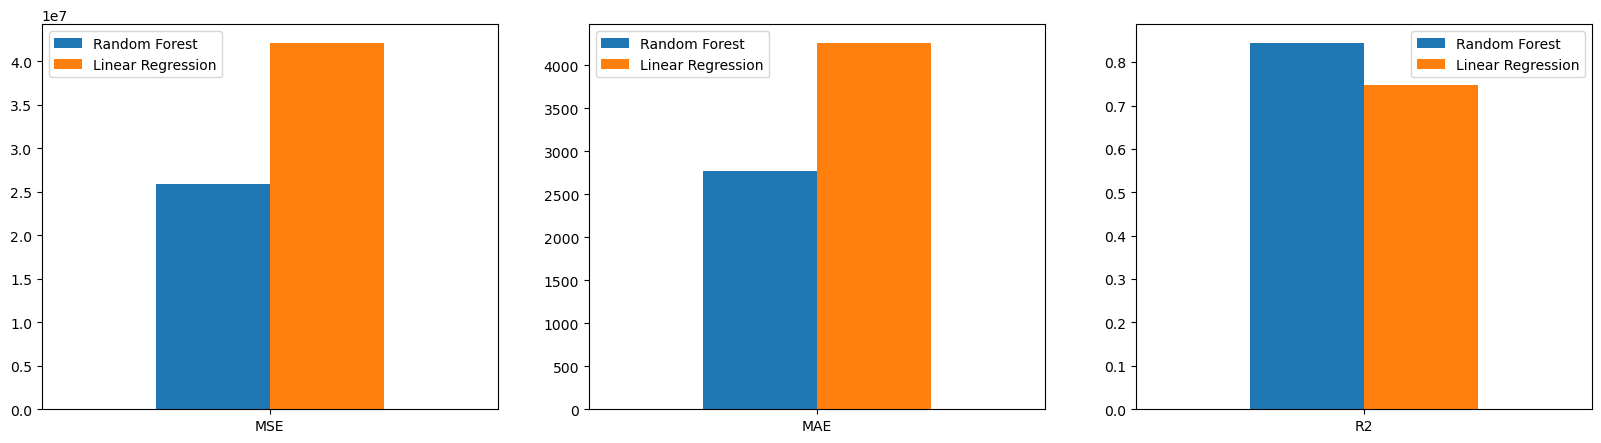

In [27]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression Random Forest model with lower MSE and MAE and higher R2.

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [28]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [29]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))